In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Research_process/local_A

/content/drive/.shortcut-targets-by-id/1JvnucXAld-pNU5hP85UfRtyVkjV2AWlq/Research_process/local_A


In [3]:
!ls -la

total 16
drwx------ 2 root root 4096 Nov 15 09:36 coreLib
drwx------ 2 root root 4096 Nov 27 17:47 ensemble_models
drwx------ 2 root root 4096 Nov 15 16:19 MODEL_DIR
drwx------ 2 root root 4096 Nov 15 16:19 models


In [4]:
import os
import random
import shutil

data_path = "/content/drive/MyDrive/Research_process/data/"

# path to destination folders
train_folder = os.path.join(data_path, 'train')
val_folder = os.path.join(data_path, 'eval')
test_folder = os.path.join(data_path, 'test')

# Define a list of image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# Create a list of image filenames in 'data_path'
imgs_list = [filename for filename in os.listdir(data_path) if os.path.splitext(filename)[-1] in image_extensions]

# Sets the random seed
random.seed(42)

# Shuffle the list of image filenames
random.shuffle(imgs_list)

# determine the number of images for each set
train_size = int(len(imgs_list) * 0.7)
val_size = int(len(imgs_list) * 0.15)
test_size = int(len(imgs_list) * 0.15)

# Create destination folders if they don't exist
for folder_path in [train_folder, val_folder, test_folder]:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Copy image files to destination folders
for i, f in enumerate(imgs_list):
    if i < train_size:
        dest_folder = train_folder
    elif i < train_size + val_size:
        dest_folder = val_folder
    else:
        dest_folder = test_folder
    shutil.copy(os.path.join(data_path, f), os.path.join(dest_folder, f))

In [5]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=22ae16f448e1780f3e7e2390b5a8f9059835f62a4cc30723fab61735d6137eb6
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [6]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=23f841e065baebd70a24fca32d8506b7e02077b8910b3a91aeb471b72a346882
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [7]:
!pip install tensorflow keras numpy np_utils


In [8]:
import tensorflow as tf
import os


print(tf.__version__)
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.15.0
Running on TPU  


REPLICAS:  8


In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
# Import ImageDataGenerator, load_img, img_to_array, and array_to_img from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import pickle
import os
import tensorflow as tf
from tensorflow import keras
from keras import utils
from tensorflow.keras import utils
#from keras.utils import utils
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model

# Import ImageDataGenerator from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix

#from coreLib.utils_cnn import *
#from coreLib.utils_ensemble import *
import argparse

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from keras import utils
from tensorflow.keras import utils
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix

In [10]:
def augment(path,IMG_DIM):

  datagen = ImageDataGenerator(rotation_range=40,width_shift_range=.2,height_shift_range=.2,shear_range=.2,zoom_range=.2,horizontal_flip=True,fill_mode='nearest')

  #to list all directories in a specific folder
  directories = os.listdir(path)

  files_path = []
  labels = []
  for i in range(len(directories)):
    ls = []
    curPath = path +'/' +directories[i] + '/*'
    ls = glob.glob(curPath)
    temp = []
    for img in ls:
      x = img_to_array(load_img(img,target_size = IMG_DIM))
      x = x.reshape((1,)+x.shape)
      temp.append(x)

    i = 0
    target = 800
    for batch in datagen.flow(temp,batch_size=4,save_to_dir=curPath[:-1],save_format='jpg'):
      i += 1
      if len(ls) + i*4>800:
        break

In [11]:
#Creating Frame
def createFrame(path,IMG_DIM):
  train_imgs = []
  labels = []
  #getting all folder name
  directories = os.listdir(path)
  for i in range(len(directories)):
    ls = []
    temp = []
    curPath = path +'/' +directories[i] + '/*'
    #getting all files name
    ls = glob.glob(curPath)
    for img in ls:
      x = img_to_array(load_img(img,target_size = IMG_DIM))
      temp.append(x)

    #print(len(ls))
    train_imgs  = train_imgs + temp
    label = []
    label = [i]*len(ls)
    labels += label

  df = pd.DataFrame(list(zip(train_imgs,labels)))
  df = df.sample(frac = 1)
  return df

In [12]:

#Fuzzy Rank-based Ensemble:
def getScore(model,test_imgs):
  res = model.predict(test_imgs)
  return res

def generateRank1(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.exp(-((scores[i]-1)**2)/2.0)
  return rank

def generateRank2(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.tanh(((scores[i]-1)**2)/2)
  return rank

def doFusion(res1,res2,res3,label,class_no):
  cnt = 0
  id = []
  for i in range(len(res1)):
      rank1 = generateRank1(res1[i],class_no)*generateRank2(res1[i],class_no)
      rank2 = generateRank1(res2[i],class_no)*generateRank2(res2[i],class_no)
      rank3 = generateRank1(res3[i],class_no)*generateRank2(res3[i],class_no)
      rankSum = rank1 + rank2 + rank3
      rankSum = np.array(rankSum)
      scoreSum = 1 - (res1[i] + res2[i] + res3[i])/3
      scoreSum = np.array(scoreSum)

      fusedScore = (rankSum.T)*scoreSum
      cls = np.argmin(rankSum)
      if cls<class_no and label[i][cls]== 1:
          cnt += 1
      id.append(cls)
  print(cnt/len(res1))
  return id

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_confusion_matrix():
    # Calculate the confusion matrix
    cm = confusion_matrix()

    # Create a DataFrame from the confusion matrix
    df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    return df

def print_confusion_matrix(df):
    # Create a heatmap of the confusion matrix in blue
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()



In [14]:
def kFold(df):

  df['kfold'] = -1
  df = df.reset_index(drop=True)
  y = df[1]
  kf = model_selection.StratifiedKFold(n_splits=5)
  for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
    df.loc[v_,'kfold'] = f

  return df


In [15]:
def Xception_model(train_imgs, train_labels, class_no, num_epochs=20):
    print("-------------------------------------XCEPTION--------------------------------------------")
    input_shape_xception = (128, 128, 3)
    xception_model = keras.applications.Xception(include_top=False, weights="imagenet", input_tensor=None, input_shape=input_shape_xception, pooling=None)
    xception_model.trainable = True
    for layer in xception_model.layers:
        layer.trainable = False

    layer = keras.layers.Flatten()(xception_model.output)
    layer = keras.layers.Dense(units=1024, activation='relu')(layer)
    layer = keras.layers.Dropout(0.2)(layer)
    layer = keras.layers.Dense(units=128, activation='relu')(layer)
    layer = keras.layers.Dense(units=class_no, activation='softmax')(layer)

    model1 = keras.models.Model(xception_model.input, outputs=layer)
    model1.compile(optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])

    history = model1.fit(train_imgs, train_labels, batch_size=32, epochs=num_epochs, verbose=1)
    print("------------------------------------------------------------------------------------------")
    return model1


In [16]:
import keras
from keras.applications import DenseNet121

def DenseNet121_model(train_imgs, train_labels, class_no, num_epochs=20):
    print("-------------------------------------DENSENET121--------------------------------------------")

    # Use DenseNet121 model instead of DenseNet201
    input_shape_densenet = (128, 128, 3)
    densenet_model = DenseNet121(include_top=False, weights="imagenet", input_tensor=None, input_shape=input_shape_densenet, pooling=None)

    # Make the base layers non-trainable (you can set which layers to train if necessary)
    densenet_model.trainable = True
    for layer in densenet_model.layers:
        layer.trainable = False  # Freeze all layers initially

    # Adding custom classification layers on top
    layer = keras.layers.Flatten()(densenet_model.output)
    layer = keras.layers.Dense(units=1024, activation='relu')(layer)
    layer = keras.layers.Dropout(0.2)(layer)
    layer = keras.layers.Dense(units=128, activation='relu')(layer)
    layer = keras.layers.Dense(units=class_no, activation='softmax')(layer)

    # Create the complete model
    model2 = keras.models.Model(densenet_model.input, outputs=layer)

    # Compile the model with a small learning rate
    model2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])

    # Train the model
    history = model2.fit(train_imgs, train_labels, batch_size=32, epochs=num_epochs, verbose=1)

    print("------------------------------------------------------------------------------------------")
    return model2


In [17]:
import keras
from keras.applications import MobileNet

def MobileNet_model(train_imgs, train_labels, class_no, num_epochs=20):
    print("-------------------------------------MOBILENET--------------------------------------------")

    # Use MobileNet model instead of MobileNetV2
    input_shape_mobilenet = (128, 128, 3)
    mobilenet_model = MobileNet(include_top=False, weights="imagenet", input_tensor=None, input_shape=input_shape_mobilenet, pooling=None)

    # Make the base layers non-trainable (you can set which layers to train if necessary)
    mobilenet_model.trainable = True
    for layer in mobilenet_model.layers:
        layer.trainable = False  # Freeze all layers initially

    # Adding custom classification layers on top
    layer = keras.layers.Flatten()(mobilenet_model.output)
    layer = keras.layers.Dense(units=1024, activation='relu')(layer)
    layer = keras.layers.Dropout(0.2)(layer)
    layer = keras.layers.Dense(units=128, activation='relu')(layer)
    layer = keras.layers.Dense(units=class_no, activation='softmax')(layer)

    # Create the complete model
    model3 = keras.models.Model(mobilenet_model.input, outputs=layer)

    # Compile the model with a small learning rate
    model3.compile(optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['acc'])

    # Train the model
    history = model3.fit(train_imgs, train_labels, batch_size=32, epochs=num_epochs, verbose=1)

    print("------------------------------------------------------------------------------------------")
    return model3


In [18]:
def argsParser(path1, num_epochs):
  #arg_parse = argparse.ArgumentParser()
  parser = argparse.ArgumentParser()
  parser = argparse.ArgumentParser()
  parser.add_argument('--data_directory', type=str, default = '.', help='Directory where the image data is stored')
  parser.add_argument('--epochs', type=int, default = 20, help='Number of Epochs of training')
  parser.add_argument("-f", required=False)

  args = vars(parser.parse_args())

  return args

  path1 = args.data_directory
  if path1[-1]=='/content/drive/MyDrive/Research_process/data/train/':
    path1 = path1[:-1]

  num_epochs = args.epochs


----------------------------------------------------FOLD NO 1-------------------------------------------------------
-------------------------------------XCEPTION--------------------------------------------
83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/2
504/504 [==============================] - 1588s 3s/step - loss: 0.5826 - acc: 0.8030
Epoch 2/2
504/504 [==============================] - 1575s 3s/step - loss: 0.2144 - acc: 0.9327
------------------------------------------------------------------------------------------
-------------------------------------MOBILENET--------------------------------------------
17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/2
504/504 [==============================] - 468s 924ms/step - loss: 0.4385 - acc: 0.8493
Epoch 2/2
504/504 [==============================] - 466s 925ms/step - loss: 0.0514 - acc: 0.9852
------------------------------------------------------------------------------------------
--

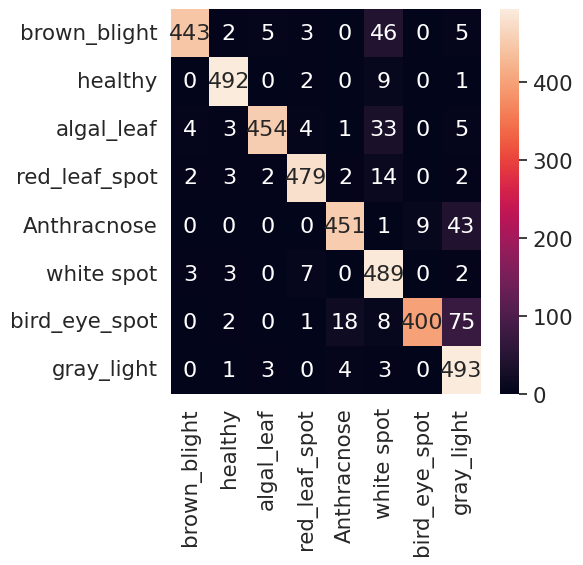

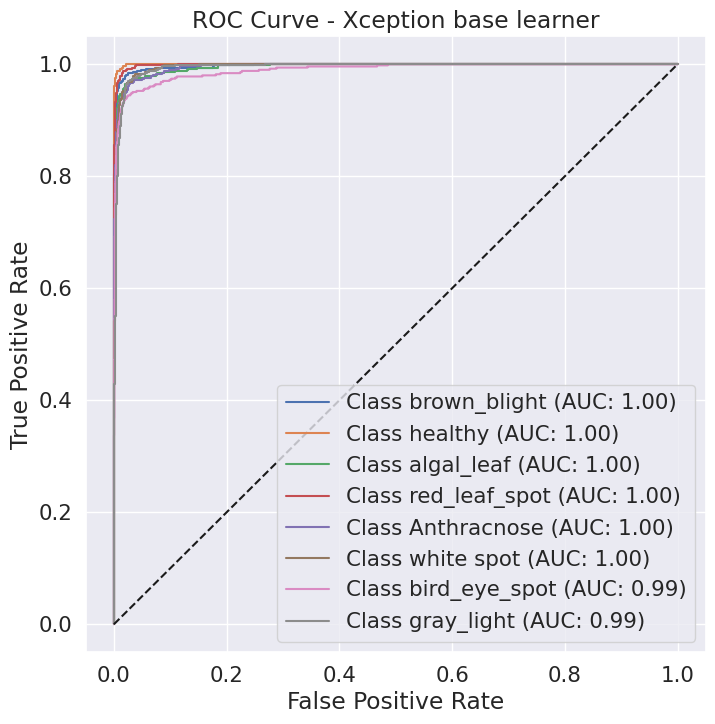

126/126 [==============================] - 59s 461ms/step
MobileNet base learner
               precision    recall  f1-score   support

 brown_blight     0.9882    1.0000    0.9941       504
      healthy     0.9960    0.9921    0.9940       504
   algal_leaf     1.0000    0.9821    0.9910       504
red_leaf_spot     0.9786    0.9960    0.9872       504
  Anthracnose     1.0000    0.9583    0.9787       504
   white spot     0.9820    0.9742    0.9781       504
bird_eye_spot     0.9597    0.9921    0.9756       504
   gray_light     0.9882    0.9960    0.9921       504

     accuracy                         0.9864      4032
    macro avg     0.9866    0.9864    0.9864      4032
 weighted avg     0.9866    0.9864    0.9864      4032



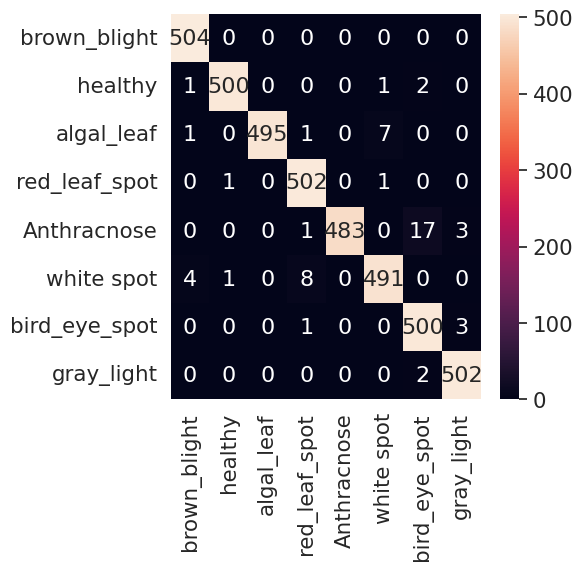

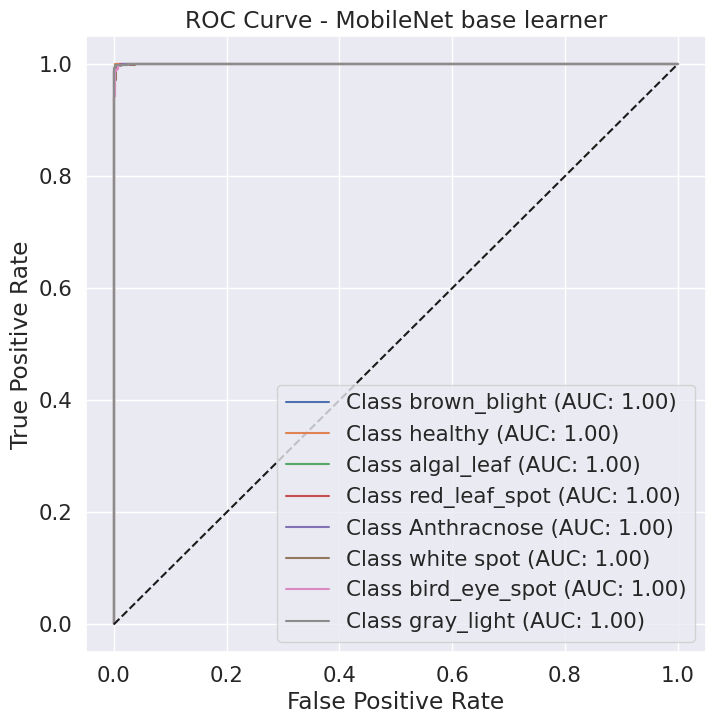

126/126 [==============================] - 224s 2s/step
DenseNet121 base learner
               precision    recall  f1-score   support

 brown_blight     0.9360    0.9861    0.9604       504
      healthy     0.9581    0.9980    0.9776       504
   algal_leaf     0.9958    0.9365    0.9652       504
red_leaf_spot     0.9959    0.9722    0.9839       504
  Anthracnose     0.9870    0.9048    0.9441       504
   white spot     0.9659    0.9544    0.9601       504
bird_eye_spot     0.9399    0.9306    0.9352       504
   gray_light     0.9002    0.9841    0.9403       504

     accuracy                         0.9583      4032
    macro avg     0.9598    0.9583    0.9584      4032
 weighted avg     0.9598    0.9583    0.9584      4032



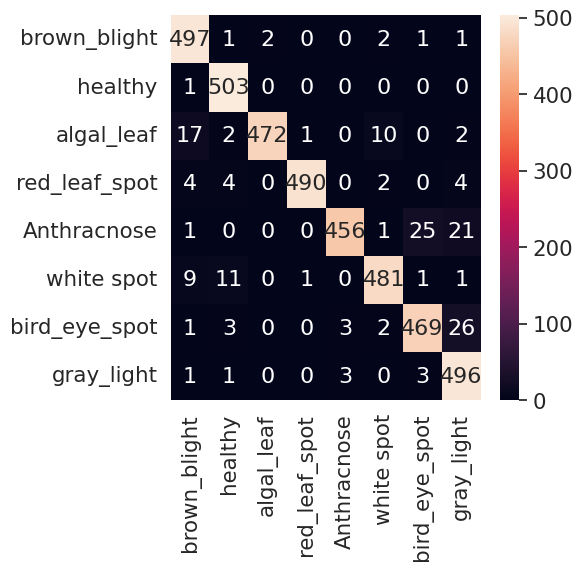

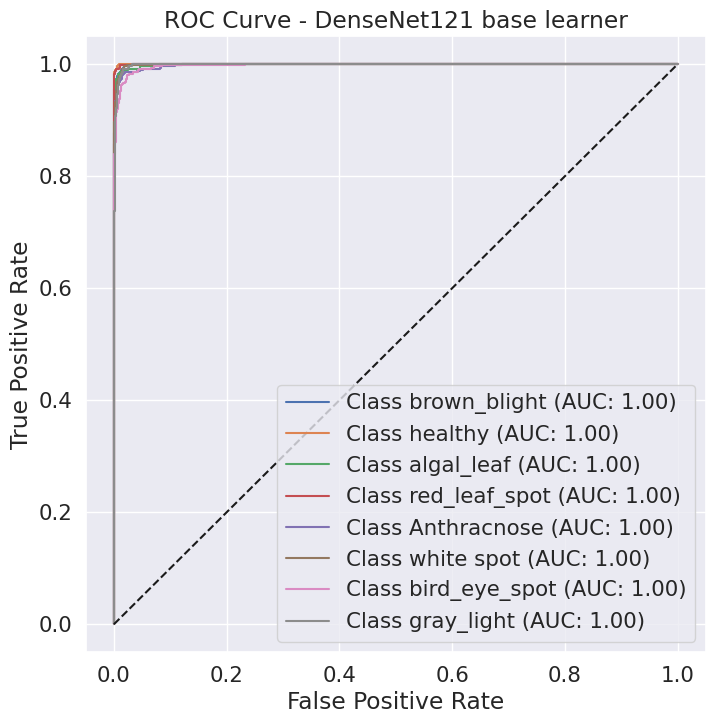

126/126 [==============================] - 224s 2s/step
0.986359126984127
Ensembled
               precision    recall  f1-score   support

 brown_blight     0.9902    1.0000    0.9951       504
      healthy     0.9960    1.0000    0.9980       504
   algal_leaf     1.0000    0.9683    0.9839       504
red_leaf_spot     0.9980    0.9980    0.9980       504
  Anthracnose     0.9980    0.9683    0.9829       504
   white spot     0.9824    0.9960    0.9892       504
bird_eye_spot     0.9918    0.9603    0.9758       504
   gray_light     0.9385    1.0000    0.9683       504

     accuracy                         0.9864      4032
    macro avg     0.9869    0.9864    0.9864      4032
 weighted avg     0.9869    0.9864    0.9864      4032



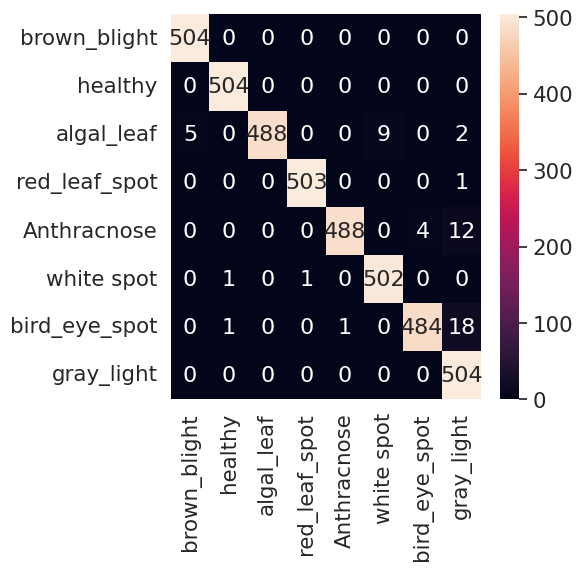

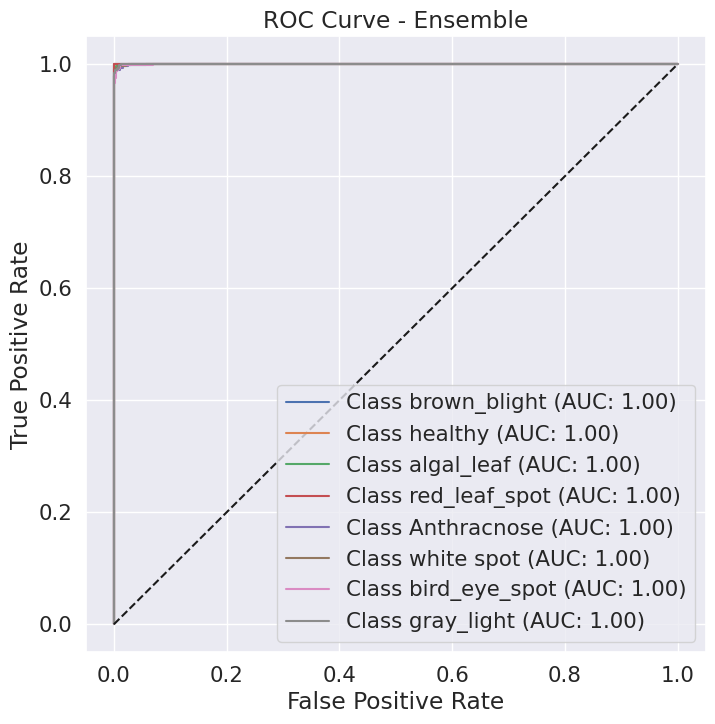

--------------------------------------------------END OF FOLD NO 1--------------------------------------------------------


In [25]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.applications import MobileNet, DenseNet121, Xception  # Import MobileNet and DenseNet121

# Parameters and paths
path1 = '/content/drive/MyDrive/Research_process/data/train/'  # Change this to your actual path
num_epochs = 2
IMG_WIDTH, IMG_HEIGHT = 128, 128
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT, 3)

# Dataset preparation
df = createFrame(path1, IMG_DIM)
df = kFold(df)
target_names = os.listdir(path1)
num_classes = len(target_names)

# Helper function for plotting ROC curve for multiclass
def plot_roc_curve(y_true, y_pred, class_names, title):
    plt.figure(figsize=(8, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC: {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# K-Fold cross-validation
for i in range(1, 2):
    print(f"----------------------------------------------------FOLD NO {i}-------------------------------------------------------")
    dfTrain = df[df['kfold'] != i]
    dfTest = df[df['kfold'] == i]

    train_imgs = np.array(list(dfTrain[0])) / 255
    train_labels = np.array(dfTrain[1])
    encoder = LabelEncoder()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    train_labels = to_categorical(train_labels)

    test_imgs = np.array(list(dfTest[0])) / 255
    test_labels = np.array(dfTest[1])
    encoder = LabelEncoder()
    encoder.fit(test_labels)
    test_labels = encoder.transform(test_labels)
    test_labels = to_categorical(test_labels)

    # Train each base learner
    base_learners = [
        ("Xception", Xception_model(train_imgs, train_labels, class_no=num_classes, num_epochs=num_epochs)),
        ("MobileNet", MobileNet_model(train_imgs, train_labels, class_no=num_classes, num_epochs=num_epochs)),  # Changed to MobileNet
        ("DenseNet121", DenseNet121_model(train_imgs, train_labels, class_no=num_classes, num_epochs=num_epochs))  # Changed to DenseNet121
    ]

    # Evaluate each base learner
    for name, model in base_learners:
        predictions = model.predict(test_imgs)
        predicted_labels = np.argmax(predictions, axis=-1)
        actual_labels = np.argmax(test_labels, axis=-1)

        # Classification report and confusion matrix
        print(f'{name} base learner')
        print(classification_report(actual_labels, predicted_labels, target_names=target_names, digits=4))

        con_mat = confusion_matrix(actual_labels, predicted_labels)
        df_cm = pd.DataFrame(con_mat, index=target_names, columns=target_names)
        plt.figure(figsize=(5, 5))
        sn.set(font_scale=1.4)
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
        plt.show()

        # ROC Curve
        plot_roc_curve(test_labels, predictions, target_names, f"ROC Curve - {name} base learner")

    # Fusion and ensemble evaluation
    res1, res2, res3 = (model.predict(test_imgs) for _, model in base_learners)
    predictedClass = doFusion(res1, res2, res3, test_labels, class_no=num_classes)
    actual = np.argmax(test_labels, axis=-1)

    # Ensemble classification report and confusion matrix
    print('Ensembled')
    print(classification_report(actual, predictedClass, target_names=target_names, digits=4))
    con_mat = confusion_matrix(actual, predictedClass)
    df_cm = pd.DataFrame(con_mat, index=target_names, columns=target_names)
    plt.figure(figsize=(5, 5))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
    plt.show()

    # Ensemble ROC Curve
    ensemble_preds = (res1 + res2 + res3) / 3  # Averaging predictions for ensemble
    plot_roc_curve(test_labels, ensemble_preds, target_names, "ROC Curve - Ensemble")

    print(f"--------------------------------------------------END OF FOLD NO {i}--------------------------------------------------------")
